<a href="https://colab.research.google.com/github/Ovocode05/NeuroDeff/blob/main/LTNE_model2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from itertools import product
import math
import pathlib
import os
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from typing import Dict, Tuple, List

In [15]:
!pip install deepxde

In [16]:
import deepxde as dde

In [17]:
def ode_system(n, y, config:dict) -> list:
    T_f = y[:, 0:1]
    T_s = y[:, 1:2]

    # Compute first derivatives (jacobian) - only j=0 for 1D problem
    T_f_n = dde.grad.jacobian(T_f, n)
    T_s_n = dde.grad.jacobian(T_s, n)

    # Compute second derivatives (hessian) - only j=0 for 1D problem
    T_f_nn = dde.grad.hessian(T_f, n)
    T_s_nn = dde.grad.hessian(T_s, n)

    # Dynamic parameter handling
    def get_param(name):
        val = config["physics"][name]
        if name in config["physics"]["varying_params"]:
            if callable(val):
                return val(n)
            elif isinstance(val, (list, np.ndarray)):
                return val
        return val

    eps = get_param('eps')
    k = get_param('k')
    delta = get_param('delta')
    beta = get_param('beta')
    Bi = get_param('Bi')

    # Equations
    eqn1 = (eps * k * (1 + delta * T_f) * T_f_nn +
            eps * k * delta * (T_f_n**2) +
            Bi * (T_s - T_f) - 1 - beta)

    eqn2 = ((1 - eps) * (1 + delta * T_s) * T_s_nn +
            (1 - eps) * delta * (T_s_n**2) -
            Bi * (T_s - T_f) + beta)

    return [eqn1, eqn2]

In [18]:
# Define geometry (1D domain from 0 to 1)
geom = dde.geometry.Interval(0, 1)

# Boundary conditions
def boundary_right(x, on_boundary):
    return on_boundary and np.isclose(x[0], 1.0)

def boundary_left(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0.0)

# Dirichlet BC at x=1
bc_Tf_right = dde.DirichletBC(geom, lambda x: 0, boundary_right, component=0)
bc_Ts_right = dde.DirichletBC(geom, lambda x: 0, boundary_right, component=1)

# Neumann BC at x=0
bc_Tf_left = dde.NeumannBC(geom, lambda x: 0, boundary_left, component=0)
bc_Ts_left = dde.NeumannBC(geom, lambda x: 0, boundary_left, component=1)

In [19]:
class PINNTrainer:
  def __init__(self, config: Dict):
    self.config = config #hyperparameters, geometry, etc

  def build_model(self, data: dde.data) -> dde.Model:
    """ Generic model builder """
    nn = dde.maps.FNN(
        [1] + [self.config["network"]["neurons"]] * self.config["network"]["layers"] + [2],
        self.config["training"]["activation"],
        "Glorot normal",
     )

    return dde.Model(data, nn)

  def train(self, model: dde.Model) -> dde.Model:
    """ Generic model trainer """
    model.compile("adam", lr = self.config["training"]["lr"], loss_weights = self.config["training"]["lose_weights"])
    losshistory, train_state = model.train(iterations=self.config["training"]["epochs"], display_every = self.config["training"]["display_every"],
                                           external_trainable_variables=self.config["training"]["extra_weights"])

    model.compile("L-BFGS-B")
    losshistory, train_state = model.train()
    return model, losshistory, train_state

In [20]:
#validation
def relation_dict(n: np.ndarray) -> dict:
  omega = [1.0,2.0,3.0]
  RELATIONS = {
      "relation_2" : {
            "network": { "neurons":64, "layers":3},  # Same as before
            "training": {"activation":"swish", "lr":0.001,
                         "lose_weights": [1e3, 1e3, 1e4, 1e4, 1e2, 1e2],
                         "epochs":10000, "display_every":1000, "extra_weights": [tf.Variable(1.0, dtype=tf.float32, trainable=True),
                                 tf.Variable(1.0, dtype=tf.float32, trainable=True) ] },
            "physics": {
                "eps": [0.1, 0.6],
                "k": 25,
                "delta": -0.2,
                "beta": 10,
                "Bi": [lambda x: 50*(1-x),
                       lambda x: 50*(1-x**2),
                       lambda x: 50*(1+x),
                       lambda x: 50*(1+x**2)],
                "varying_params": ["Bi", "eps"]  # Specify which params vary
            }
         },
      "relation_3" : {
          "network": { "neurons":64, "layers":3},  # Same as before
          "training": {"activation":"swish", "lr":0.001,
                        "lose_weights": [1e3, 1e3, 1e4, 1e4, 1e2, 1e2],
                        "epochs":10000, "display_every":1000, "extra_weights": [tf.Variable(1.0, dtype=tf.float32, trainable=True),
                                 tf.Variable(1.0, dtype=tf.float32, trainable=True) ] },
            "physics": {
                "eps": [0.1, 0.6],
                "k": 25,
                "delta": -0.2,
                "beta": 10,
                "Bi": 100*tf.sin(tf.constant(np.pi, dtype=n.dtype) * (omega)* n)**2,
                "varying_params": ["Bi", "eps"]  # Specify which params vary
            }
      },
      "relation_4": {
           "network": { "neurons":64, "layers":3},  # Same as before
            "training": {"activation":"swish", "lr":0.001,
                         "lose_weights": [1e3, 1e3, 1e4, 1e4, 1e2, 1e2],
                         "epochs":10000, "display_every":1000, "extra_weights": [tf.Variable(1.0, dtype=tf.float32, trainable=True),
                                 tf.Variable(1.0, dtype=tf.float32, trainable=True) ] },
            "physics": {
                "eps": 0.1,
                "k": 25,
                "delta":[1, 0.7, 0.4, 0.1, -0.2, -0.5],
                "beta": 10,
                "Bi": [100*tf.sin(tf.constant(np.pi, dtype=n.dtype) * tf.constant(omega, dtype=n.dtype) * n)**2, 50*(1- n**2)],
                "varying_params": ["Bi", "delta"]  # Specify which params vary
            }
      },
      "relation_5":{
            "network": { "neurons":64, "layers":3},  # Same as before
            "training": {"activation":"swish", "lr":0.001,
                         "lose_weights": [1e3, 1e3, 1e4, 1e4, 1e2, 1e2],
                         "epochs":10000, "display_every":1000, "extra_weights": [tf.Variable(1.0, dtype=tf.float32, trainable=True),
                                 tf.Variable(1.0, dtype=tf.float32, trainable=True) ] },
            "physics": {
                "eps": 0.1,
                "k": 25,
                "delta":-0.2,
                "beta":[0,5,10,15,20],
                "Bi": [lambda x: 100*tf.sin(tf.constant(np.pi, dtype=n.dtype) * tf.constant(omega, dtype=n.dtype) * x)**2,
                       lambda x: 50*(1- x**2)],
                "varying_params": ["Bi", "delta"]  # Specify which params vary
            }
      },
      "relation_6":{
          "network": { "neurons":64, "layers":3},  # Same as before
          "training": {"activation":"swish", "lr":0.001,
                       "lose_weights": [1e3, 1e3, 1e4, 1e4, 1e2, 1e2],
                       "epochs":10000, "display_every":1000, "extra_weights": [tf.Variable(1.0, dtype=tf.float32, trainable=True),
                                 tf.Variable(1.0, dtype=tf.float32, trainable=True) ] },
            "physics": {
                "eps": 0.1,
                "k":[1,10,20,30,40,50],
                "delta":-0.2,
                "beta":[0,5,10,15,20],
                "Bi": [lambda x: 100*tf.sin(tf.constant(np.pi, dtype=n.dtype) * tf.constant(omega, dtype=n.dtype) * x)**2,
                       lambda x: 50*(1- x**2)],
                "varying_params": ["Bi", "delta"]  # Specify which params vary
            }
      }
  }
  return RELATIONS

In [21]:
from copy import deepcopy
from itertools import product

In [24]:
def run_relation(relation_name: str, n: np.ndarray):
    """Handles any relation from the config without deepcopy issues"""
    config = relation_dict(n)[relation_name]
    results = {}

    # Prepare parameter combinations
    varying_params = config["physics"]["varying_params"]
    param_values = [
        config["physics"][p] if isinstance(config["physics"][p], (list, np.ndarray)) else [config["physics"][p]]
        for p in varying_params
    ]

    for combo in product(*param_values):
        param_str = "_".join(f"{p}={v}" for p,v in zip(varying_params, combo))
        print(f"\nTraining {relation_name} with {param_str}")

        # Create new config without deepcopy
        current_physics = config["physics"].copy()
        for p, v in zip(varying_params, combo):
            current_physics[p] = v

        current_config = {
            "network": config["network"],
            "training": config["training"],
            "physics": current_physics
        }

        # Training setup
        ode_wrapped = lambda x, y: ode_system(x, y, current_config)
        data = dde.data.PDE(
            geom,
            ode_wrapped,
            [bc_Tf_right, bc_Ts_right, bc_Tf_left, bc_Ts_left],
            num_domain=500,
            num_boundary=20
        )

        # Build and train model
        nn = dde.maps.FNN(
            [1] + [current_config["network"]["neurons"]] * current_config["network"]["layers"] + [2],
            current_config["training"]["activation"],
            "Glorot normal"
        )
        model = dde.Model(data, nn)

        model.compile(
            "adam",
            lr=current_config["training"]["lr"],
            loss_weights=current_config["training"]["lose_weights"],
            external_trainable_variables=current_config["training"]["extra_weights"]
        )
        losshistory, _ = model.train(epochs=current_config["training"]["epochs"], display_every=1000)
        model.compile("L-BFGS-B")
        losshistory, train_state = model.train()

        # Store results
        T_pred = model.predict(n)
        results[param_str] = {
            "x": n.flatten(),
            "T_f": T_pred[:, 0:1],
            "T_s": T_pred[:, 1:2],
            "params": dict(zip(varying_params, combo))
        }

        # Save plots
        os.makedirs(f"plots/{relation_name}", exist_ok=True)
        dde.saveplot(losshistory, train_state, issave=True, isplot=True, output_dir=f"plots/{relation_name}/{param_str}")

    return results



Training relation_2 with Bi=<function relation_dict.<locals>.<lambda> at 0x7bc7b1bfe480>_eps=0.1
Compiling model...
Building feed-forward neural network...
'build' took 0.062527 s

'compile' took 2.405278 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.35e+05, 1.13e+05, 1.14e+01, 2.48e+01, 8.63e-02, 2.08e-01]    [1.35e+05, 1.13e+05, 1.14e+01, 2.48e+01, 8.63e-02, 2.08e-01]    []  
1000      [8.83e+00, 5.26e+01, 9.94e-01, 9.04e-01, 4.22e+00, 4.45e-01]    [8.83e+00, 5.26e+01, 9.94e-01, 9.04e-01, 4.22e+00, 4.45e-01]    []  
2000      [4.33e+00, 1.57e+01, 4.94e-02, 3.78e-02, 4.62e+00, 1.96e+00]    [4.33e+00, 1.57e+01, 4.94e-02, 3.78e-02, 4.62e+00, 1.96e+00]    []  
3000      [1.41e+00, 5.12e+00, 4.26e-03, 5.23e-03, 2.75e+00, 1.71e+00]    [1.41e+00, 5.12e+00, 4.26e-03, 5.23e-03, 2.75e+00, 1.71e+00]    []  
4000      [3.98e-01, 1.39e+00, 1.89e-03, 5.39e-04,

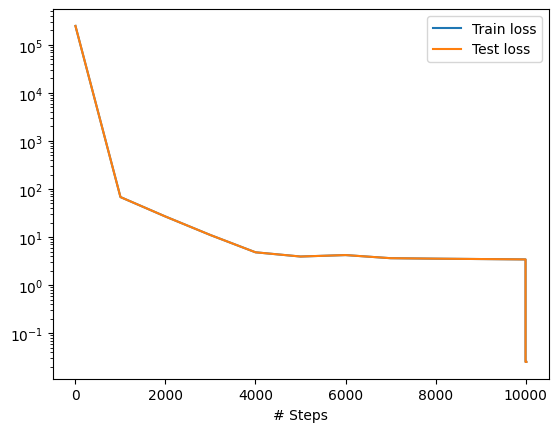

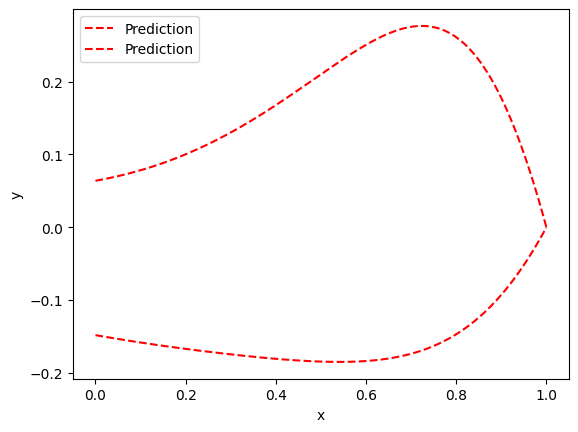


Training relation_2 with Bi=<function relation_dict.<locals>.<lambda> at 0x7bc7b1bfe480>_eps=0.6
Compiling model...
Building feed-forward neural network...
'build' took 0.061793 s

'compile' took 2.168045 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.32e+05, 1.13e+05, 1.14e+01, 2.48e+01, 8.63e-02, 2.08e-01]    [1.32e+05, 1.13e+05, 1.14e+01, 2.48e+01, 8.63e-02, 2.08e-01]    []  
1000      [1.00e+01, 1.50e+02, 3.06e+00, 1.79e-01, 3.05e+00, 2.85e+01]    [1.00e+01, 1.50e+02, 3.06e+00, 1.79e-01, 3.05e+00, 2.85e+01]    []  
2000      [5.19e+00, 9.46e+01, 1.81e+00, 3.87e-01, 8.05e-03, 1.58e+01]    [5.19e+00, 9.46e+01, 1.81e+00, 3.87e-01, 8.05e-03, 1.58e+01]    []  
3000      [4.04e+00, 4.38e+01, 3.16e-01, 1.15e-01, 1.70e+00, 5.27e+00]    [4.04e+00, 4.38e+01, 3.16e-01, 1.15e-01, 1.70e+00, 5.27e+00]    []  
4000      [9.38e-01, 1.28e+01, 3.70e-02, 2.31e-02,

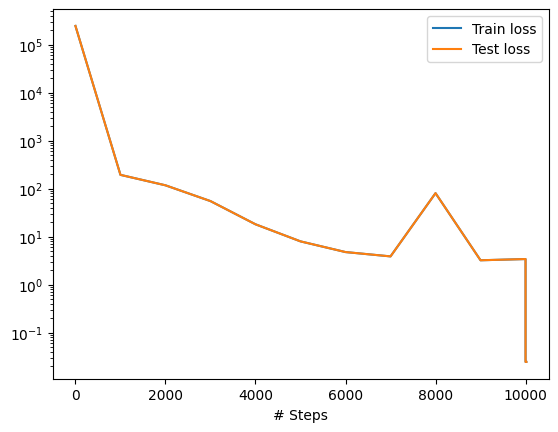

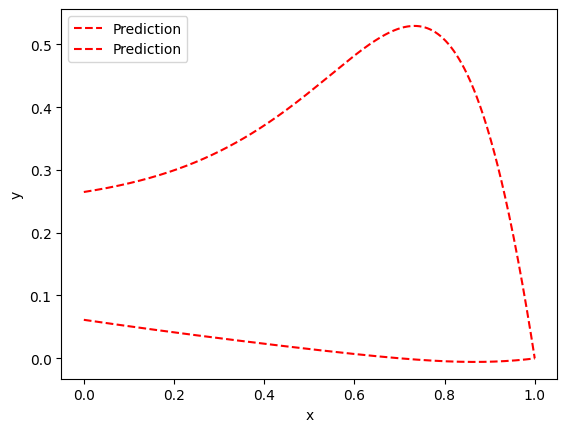


Training relation_2 with Bi=<function relation_dict.<locals>.<lambda> at 0x7bc7b1bfdc60>_eps=0.1
Compiling model...
Building feed-forward neural network...
'build' took 0.061803 s

'compile' took 2.262622 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.43e+05, 1.20e+05, 1.14e+01, 2.48e+01, 8.63e-02, 2.08e-01]    [1.43e+05, 1.20e+05, 1.14e+01, 2.48e+01, 8.63e-02, 2.08e-01]    []  
1000      [3.22e+01, 1.08e+02, 5.19e-01, 2.81e-03, 1.37e+00, 1.86e+01]    [3.22e+01, 1.08e+02, 5.19e-01, 2.81e-03, 1.37e+00, 1.86e+01]    []  
2000      [3.20e+00, 5.86e+01, 4.39e-01, 1.66e-01, 9.50e-01, 4.93e+00]    [3.20e+00, 5.86e+01, 4.39e-01, 1.66e-01, 9.50e-01, 4.93e+00]    []  
3000      [1.28e+00, 1.87e+01, 6.69e-02, 1.68e-02, 5.01e-01, 1.57e+00]    [1.28e+00, 1.87e+01, 6.69e-02, 1.68e-02, 5.01e-01, 1.57e+00]    []  
4000      [3.24e-01, 3.49e+00, 9.46e-03, 1.46e-03,

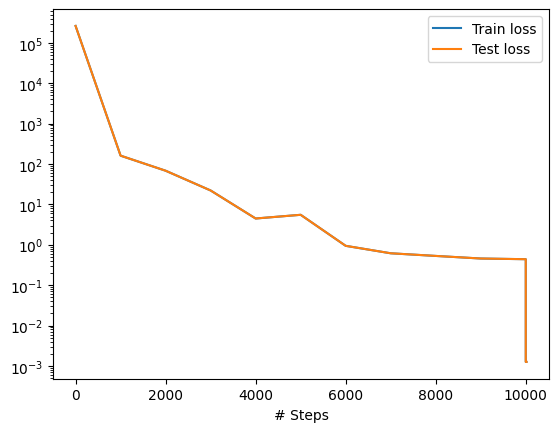

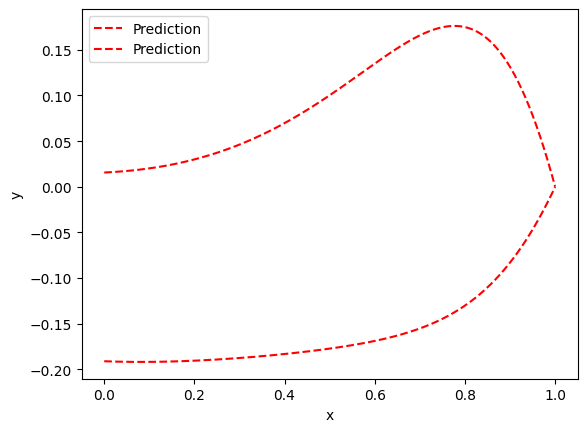


Training relation_2 with Bi=<function relation_dict.<locals>.<lambda> at 0x7bc7b1bfdc60>_eps=0.6
Compiling model...
Building feed-forward neural network...
'build' took 0.062234 s

'compile' took 2.312678 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.40e+05, 1.20e+05, 1.14e+01, 2.48e+01, 8.63e-02, 2.08e-01]    [1.40e+05, 1.20e+05, 1.14e+01, 2.48e+01, 8.63e-02, 2.08e-01]    []  
1000      [4.15e+02, 1.04e+03, 1.72e+00, 3.31e+01, 7.25e-01, 1.90e-01]    [4.15e+02, 1.04e+03, 1.72e+00, 3.31e+01, 7.25e-01, 1.90e-01]    []  
2000      [5.51e+00, 1.08e+02, 3.21e+00, 2.06e+00, 4.03e-02, 3.21e+00]    [5.51e+00, 1.08e+02, 3.21e+00, 2.06e+00, 4.03e-02, 3.21e+00]    []  
3000      [2.16e+01, 9.37e+01, 2.29e+00, 1.66e+00, 5.02e-02, 1.45e+00]    [2.16e+01, 9.37e+01, 2.29e+00, 1.66e+00, 5.02e-02, 1.45e+00]    []  
4000      [3.71e+01, 8.38e+01, 2.10e+00, 1.76e+00,

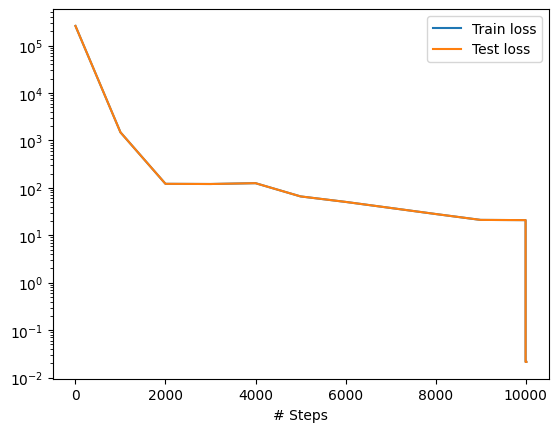

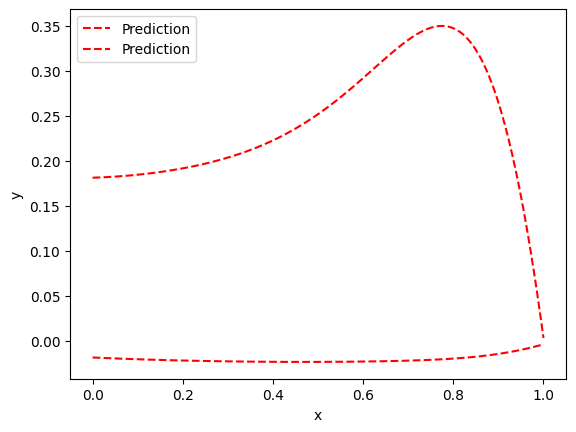


Training relation_2 with Bi=<function relation_dict.<locals>.<lambda> at 0x7bc7b1bfdf80>_eps=0.1
Compiling model...
Building feed-forward neural network...
'build' took 0.063977 s

'compile' took 2.373436 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.11e+05, 1.84e+05, 1.14e+01, 2.48e+01, 8.63e-02, 2.08e-01]    [2.11e+05, 1.84e+05, 1.14e+01, 2.48e+01, 8.63e-02, 2.08e-01]    []  
1000      [2.39e+01, 2.22e+01, 3.26e+01, 2.31e+01, 9.34e-01, 7.05e+00]    [2.39e+01, 2.22e+01, 3.26e+01, 2.31e+01, 9.34e-01, 7.05e+00]    []  
2000      [3.54e+00, 3.28e+00, 2.53e+01, 2.91e+01, 9.21e-01, 6.96e+00]    [3.54e+00, 3.28e+00, 2.53e+01, 2.91e+01, 9.21e-01, 6.96e+00]    []  
3000      [2.49e+00, 2.47e+00, 2.60e+01, 2.80e+01, 1.16e-01, 4.27e+00]    [2.49e+00, 2.47e+00, 2.60e+01, 2.80e+01, 1.16e-01, 4.27e+00]    []  
4000      [1.49e+00, 1.59e+00, 2.62e+01, 2.73e+01,

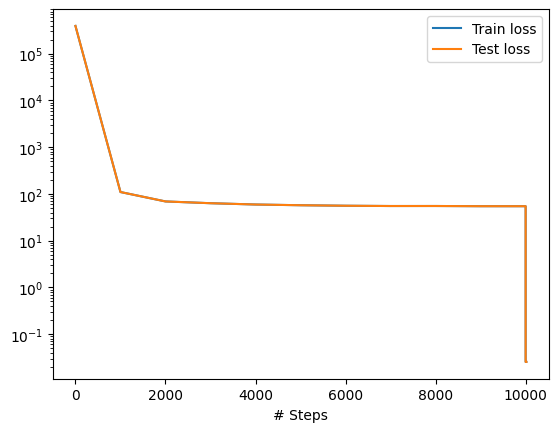

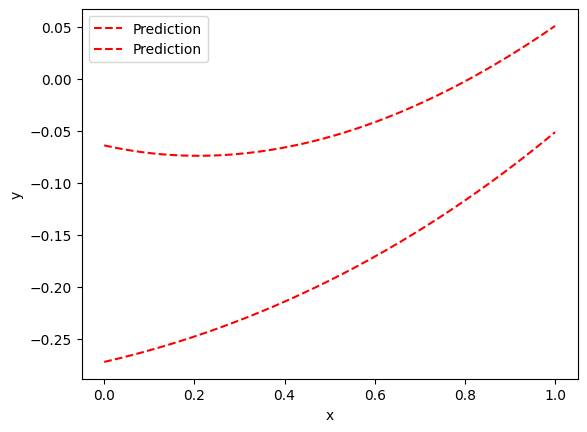


Training relation_2 with Bi=<function relation_dict.<locals>.<lambda> at 0x7bc7b1bfdf80>_eps=0.6
Compiling model...
Building feed-forward neural network...
'build' took 0.061786 s

'compile' took 2.992081 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.10e+05, 1.86e+05, 1.14e+01, 2.48e+01, 8.63e-02, 2.08e-01]    [2.10e+05, 1.86e+05, 1.14e+01, 2.48e+01, 8.63e-02, 2.08e-01]    []  
1000      [2.61e+01, 2.47e+01, 2.40e+01, 2.49e+01, 5.21e-02, 1.16e+00]    [2.61e+01, 2.47e+01, 2.40e+01, 2.49e+01, 5.21e-02, 1.16e+00]    []  
2000      [4.54e+00, 4.32e+00, 2.54e+01, 2.63e+01, 6.27e-02, 1.73e+00]    [4.54e+00, 4.32e+00, 2.54e+01, 2.63e+01, 6.27e-02, 1.73e+00]    []  
3000      [4.22e+00, 4.07e+00, 2.54e+01, 2.62e+01, 9.12e-02, 1.63e+00]    [4.22e+00, 4.07e+00, 2.54e+01, 2.62e+01, 9.12e-02, 1.63e+00]    []  
4000      [3.91e+00, 3.78e+00, 2.54e+01, 2.62e+01,

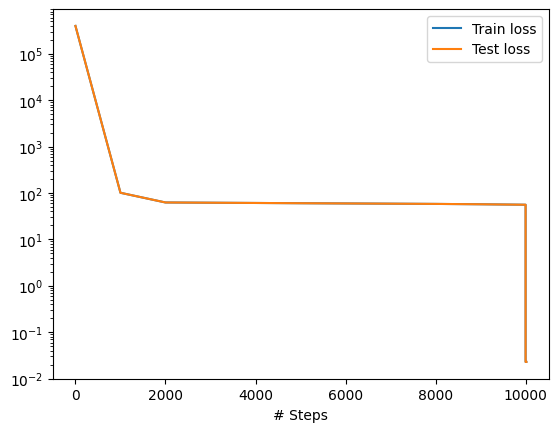

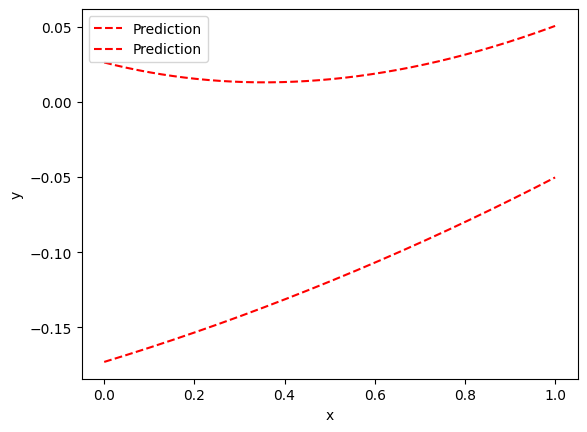


Training relation_2 with Bi=<function relation_dict.<locals>.<lambda> at 0x7bc7b1bfdb20>_eps=0.1
Compiling model...
Building feed-forward neural network...
'build' took 0.064312 s

'compile' took 2.588237 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.04e+05, 1.77e+05, 1.14e+01, 2.48e+01, 8.63e-02, 2.08e-01]    [2.04e+05, 1.77e+05, 1.14e+01, 2.48e+01, 8.63e-02, 2.08e-01]    []  
1000      [4.22e+01, 4.08e+01, 2.81e+01, 2.07e+01, 9.36e-01, 2.73e+00]    [4.22e+01, 4.08e+01, 2.81e+01, 2.07e+01, 9.36e-01, 2.73e+00]    []  
2000      [2.01e+01, 2.01e+01, 2.37e+01, 2.60e+01, 7.43e-01, 2.68e+00]    [2.01e+01, 2.01e+01, 2.37e+01, 2.60e+01, 7.43e-01, 2.68e+00]    []  
3000      [1.56e+01, 1.54e+01, 2.46e+01, 2.56e+01, 1.70e-01, 1.19e+00]    [1.56e+01, 1.54e+01, 2.46e+01, 2.56e+01, 1.70e-01, 1.19e+00]    []  
4000      [8.52e+00, 8.13e+00, 2.55e+01, 2.60e+01,

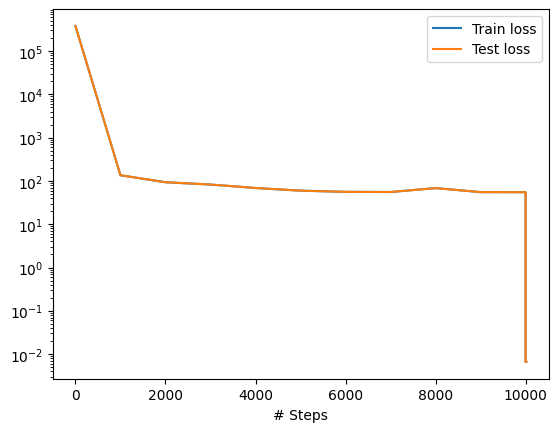

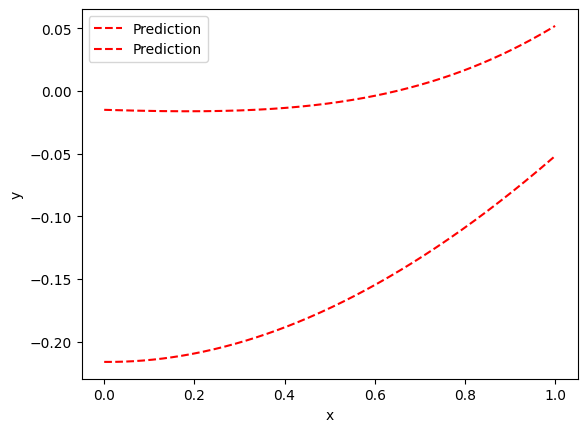


Training relation_2 with Bi=<function relation_dict.<locals>.<lambda> at 0x7bc7b1bfdb20>_eps=0.6
Compiling model...
Building feed-forward neural network...
'build' took 0.068668 s

'compile' took 2.738613 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.99e+05, 1.76e+05, 1.14e+01, 2.48e+01, 8.63e-02, 2.08e-01]    [1.99e+05, 1.76e+05, 1.14e+01, 2.48e+01, 8.63e-02, 2.08e-01]    []  
1000      [2.18e+01, 2.22e+01, 2.36e+01, 2.36e+01, 1.08e-01, 2.54e-01]    [2.18e+01, 2.22e+01, 2.36e+01, 2.36e+01, 1.08e-01, 2.54e-01]    []  
2000      [2.17e+01, 2.20e+01, 2.35e+01, 2.35e+01, 1.04e-01, 2.36e-01]    [2.17e+01, 2.20e+01, 2.35e+01, 2.35e+01, 1.04e-01, 2.36e-01]    []  
3000      [2.16e+01, 2.18e+01, 2.35e+01, 2.35e+01, 1.03e-01, 2.29e-01]    [2.16e+01, 2.18e+01, 2.35e+01, 2.35e+01, 1.03e-01, 2.29e-01]    []  
4000      [2.14e+01, 2.16e+01, 2.35e+01, 2.35e+01,

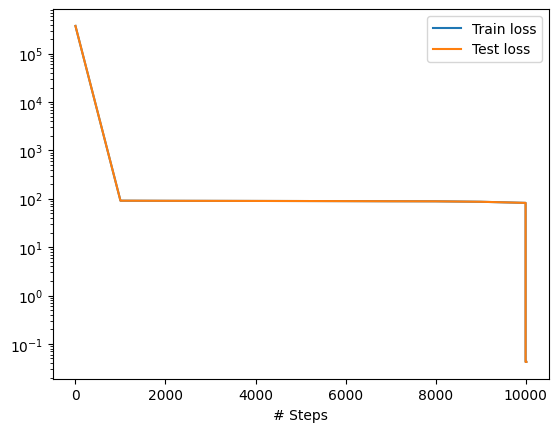

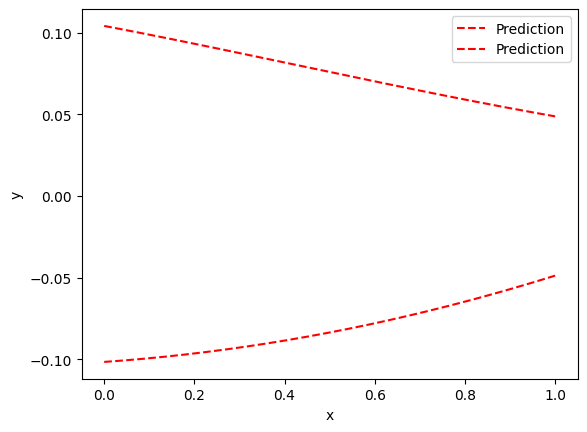


Training relation_3 with Bi=Tensor("mul_458:0", shape=(50, 3), dtype=float64)_eps=0.1
Compiling model...
Building feed-forward neural network...
'build' took 0.085986 s



TypeError: Input 'y' of 'Mul' Op has type float32 that does not match type float64 of argument 'x'.

In [25]:
from itertools import product
from copy import deepcopy
import os

n = np.linspace(0, 1, 50).reshape(-1, 1)
all_results = {}

for relation in ["relation_2", "relation_3", "relation_4", "relation_5", "relation_6"]:
    all_results[relation] = run_relation(relation, n)